<a href="https://colab.research.google.com/github/sumitthakur24/Amazon-Fine-Food-Review/blob/master/04_Amazon_Fine_Food_Reviews_(Naive_Bayes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/database.sqlite" "database.sqlite"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading Data

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

In [0]:
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head()

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False)
sorted_data.shape

(525814, 10)

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
for i in range(0,364171):
  final['Text'].values[i]=re.sub(r"http\S+", "", final['Text'].values[i])
  

In [0]:
#removing html tags
from bs4 import BeautifulSoup

for i in range(1,364171):
  soup=BeautifulSoup(final['Text'].values[i],'lxml')
  text=soup.get_text()
  final['Text'].values[i]=text

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
for i in range(0,364171):
  final['Text'].values[i]=decontracted(final['Text'].values[i])

In [0]:
#remove words with numbers 
for i in range(0,364171):
  final['Text'].values[i]=re.sub("\S*\d\S*", "", final['Text'].values[i]).strip()


In [0]:
#remove spacial character 
for i in range(0,364171):
  final['Text'].values[i]=re.sub('[^A-Za-z0-9]+', ' ', final['Text'].values[i])


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:12<00:00, 2745.16it/s]


In [0]:
len(preprocessed_reviews)

364171

In [0]:
final['cleaned_text']=preprocessed_reviews
print(final.shape)
final.head()

(364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version",I grew up reading these Sendak books and watch...,grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud it h...,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


In [0]:
#sampling 100k data(Randomly taken)
random_100k=final.sample(n=100000)
random_100k.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
474821,513498,B000612VL4,A1P37VWSAZ7TB1,Joe P,1,1,1,1321401600,Fantastic cake,I used three boxes of the red velvet cake mix ...,used three boxes red velvet cake mix company g...
205853,223062,B000UUWECC,A3QN75M2WMTYAU,"R. H. Wilkins ""RobTheGamer""",4,9,0,1245196800,"Tastes like stale, bland water to myself and m...",Ever leave a glass of water on your night stan...,ever leave glass water night stand take sip ne...
191507,207629,B000ER1EPE,A1XMUMUXUOZ7S5,Jeannie T,2,2,1,1266883200,'Monster cookies',I try to limit processed sugary foods in our d...,try limit processed sugary foods diet however ...
376337,406935,B000KEPBBY,AI0NMYA3LKXW1,"Bartok Kinski ""A casual stroll through the lu...",1,10,1,1271721600,"Bob's Red Pill Poup Mix, eggie",I tried this soup mix for the first time and i...,tried soup mix first time absolutely delicious...
279172,302504,B001EQ4JQ0,A1OM1O3UJ06TQ1,"Kudokatz ""Kudokatz""",1,1,1,1310256000,one of my favorites,I absolutely love this tea and get regular del...,absolutely love tea get regular deliveries def...


## Time based splitting

In [0]:
time_sort=random_100k.sort_values('Time',axis=0,ascending=True)
time_sort.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie Ke...,beetlejuice excellent funny movie keaton hilar...


In [0]:
x_100k=time_sort['cleaned_text']
y_100k=time_sort['Score']

## Splitting in to Train ,Test and CV

In [0]:
#splitting in to train and test
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x_100k,y_100k, test_size=0.2,random_state=0)

#train and cv
x_tr,x_cv,y_tr,y_cv=train_test_split(x_train,y_train,test_size=0.2,random_state=0)


In [0]:
y_tr.value_counts()

1    53964
0    10036
Name: Score, dtype: int64

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score,auc
import math

In [0]:
#BoW
count_vect = CountVectorizer() 

#train
count_vect.fit(x_tr)
train_bow=count_vect.transform(x_tr)

#cv
cv_bow=count_vect.transform(x_cv)

In [0]:
print('shape of train data',train_bow.shape)
print('shape of cv data',cv_bow.shape)

shape of train data (64000, 48742)
shape of cv data (16000, 48742)


In [0]:
tr_auc=[]
cv_auc=[]
Alpha=[]
al=0.00001
while (al<100000):
  Alpha.append(math.ceil(math.log(al,10)))
  mn=MultinomialNB(alpha=al)
  mn.fit(train_bow,y_tr)
  
  #pedicting cv
  cv_p=mn.predict_proba(cv_bow)
  scr_cv=roc_auc_score(y_cv, cv_p[:,1])
  cv_auc.append(scr_cv)
  print(scr_cv)
  #train
  tr_p=mn.predict_proba(train_bow)
  scr_tr=roc_auc_score(y_tr, tr_p[:,1])
  tr_auc.append(scr_tr)
  print(scr_tr)
  al=al*10

0.8178399890360837
0.9818887818470656
0.8395927653809345
0.9813087734795902
0.8643261430749271
0.9801750759012422
0.8913560397873384
0.9776456856716753
0.9132642138111972
0.971020485174135
0.9146987546614521
0.949892990858881
0.7365737567766322
0.7612858958656847
0.5669890392326977
0.5656329850223578
0.5302408503638801
0.5285765191275384
0.49289133236448524
0.4913427755994217


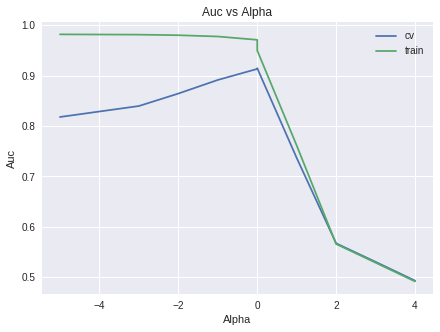

In [0]:
#plotting
plt.figure(figsize=(7,5))
plt.plot(Alpha,cv_auc, label='cv')
plt.plot(Alpha,tr_auc, label='train')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Auc')
plt.title('Auc vs Alpha')
plt.show()

## Observation:
The value of optimal alpha is 1.0

In [0]:
test_bow=count_vect.transform(x_test)

## Roc for Train and CV

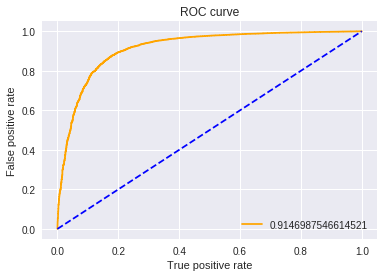

In [0]:
mn_r=MultinomialNB(alpha=1.0)
mn_r.fit(train_bow,y_tr)

pred_cv=mn_r.predict_proba(cv_bow)
fpr,tpr,threshold=roc_curve(y_cv,pred_cv[:,1])
roc_cv=metrics.auc(fpr,tpr)

plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title('ROC curve')

plt.plot(fpr,tpr, label=roc_cv, color='orange')
plt.plot([0, 1], [0, 1], 'b--')
plt.legend()
plt.show()

## Observation:
Auc Score is 0.914 which is 91%.So probability of sepration of pos and neg is 91%

## Roc for train and Test

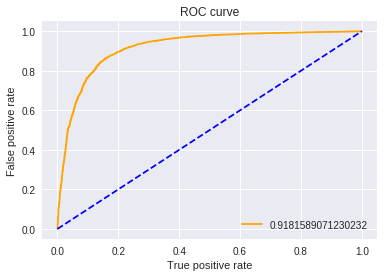

In [0]:
pred_test=mn_r.predict_proba(test_bow)
fpr,tpr,threshold=roc_curve(y_test,pred_test[:,1])
roc_test=metrics.auc(fpr,tpr)

plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title('ROC curve')

plt.plot(fpr,tpr, label=roc_test, color='orange')
plt.plot([0, 1], [0, 1], 'b--')
plt.legend()
plt.show()

## Observation:
Auc Score is 0.918 which is ~ 91%.So probability of sepration of pos and neg is 91%

              precision    recall  f1-score   support

           0       0.77      0.62      0.69      3243
           1       0.93      0.96      0.95     16757

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.85      0.79      0.82     20000
weighted avg       0.90      0.91      0.90     20000

**************************************************


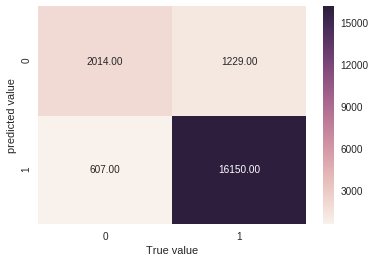

In [0]:
pred=mn_r.predict(test_bow)
print(metrics.classification_report(y_test, pred))

print('*'*50)

cnf_matrix=metrics.confusion_matrix(y_test,pred)
df=pd.DataFrame(cnf_matrix, index=[0,1], columns=[0,1])
sns.heatmap(df,annot=True,fmt='0.2f')
plt.xlabel('True value')
plt.ylabel('predicted value')
plt.show()

## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
train_tf=tf_idf_vect.fit_transform(x_tr)
#cv
cv_tf=tf_idf_vect.transform(x_cv)


In [0]:
print('shape of train data',train_tf.shape)
print('shape of cv data',cv_tf.shape)

shape of train data (64000, 37158)
shape of cv data (16000, 37158)


In [0]:
tr_auc_tf=[]
cv_auc_tf=[]
Alpha=[]
al=0.00001

while(al<100000):
  Alpha.append(math.ceil(math.log(al,10)))
  mn_tf=MultinomialNB(alpha=al)
  mn_tf.fit(train_tf,y_tr)
  
  #cv
  cv_p_tf=mn_tf.predict_proba(cv_tf)
  scr_cv_tf=roc_auc_score(y_cv,cv_p_tf[:,1])
  cv_auc_tf.append(scr_cv_tf)
  print(scr_cv_tf)
  
  #train
  tr_p_tf=mn_tf.predict_proba(train_tf)
  scr_tr_tf=roc_auc_score(y_tr,tr_p_tf[:,1])
  tr_auc_tf.append(scr_tr_tf)
  print(scr_tr_tf)
  al=al*10

0.9090073827213967
0.9899542138997114
0.9211560057031434
0.9895161903102432
0.9338000001706858
0.9887437431901447
0.9452165575027769
0.9872502427625531
0.9529953583165008
0.9837892829014716
0.9505961040841029
0.9727187945795256
0.8360401310643536
0.8572988808002997
0.697156630060147
0.7039161981805091
0.6389178294565431
0.6416323941541531
0.6143339490089024
0.616760477269599


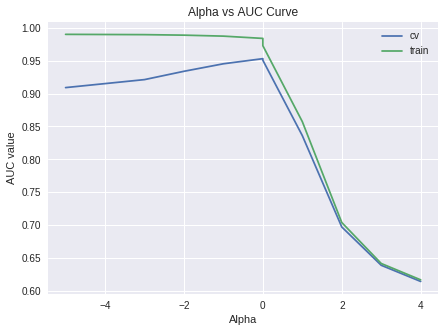

In [0]:
plt.figure(figsize=(7,5))
plt.xlabel('Alpha')
plt.ylabel('AUC value')
plt.title('Alpha vs AUC Curve')
plt.plot(Alpha, cv_auc_tf, label='cv')
plt.plot(Alpha, tr_auc_tf, label='train')
plt.legend()
plt.show()

## Observation:
The value of optimal alpha is 1.0

In [0]:
test_tf=tf_idf_vect.transform(x_test)


## Roc Curve for Train and CV

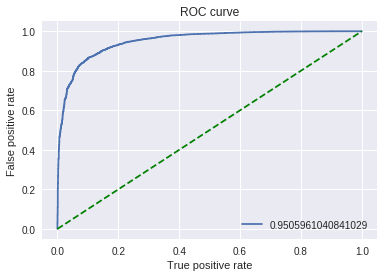

In [0]:
mn_r_tf=MultinomialNB(alpha=1.0)
mn_r_tf.fit(train_tf,y_tr)

#cv
pred_cv_tf=mn_r_tf.predict_proba(cv_tf)
fpr,tpr,threshold=roc_curve(y_cv,pred_cv_tf[:,1])
roc_auc_cv=metrics.auc(fpr,tpr)

plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title('ROC curve')

plt.plot(fpr,tpr, label=roc_auc_cv)
plt.plot([0, 1], [0, 1],'g--')
plt.legend()
plt.show()

## Observation:
Auc Score is 0.950 which is 95%.So probability of sepration of pos and neg is 95%

## Roc for Train And Test

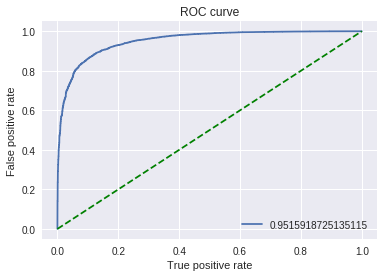

In [0]:
#test
pred_test_tf=mn_r_tf.predict_proba(test_tf)
fpr,tpr,threshold=roc_curve(y_test,pred_test_tf[:,1])
roc_auc_te=metrics.auc(fpr,tpr)

plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title('ROC curve')

plt.plot(fpr,tpr, label=roc_auc_te)
plt.plot([0, 1], [0, 1],'g--')
plt.legend()
plt.show()

## Observation:
Auc Score is 0.951 which is 95%.So probability of sepration of pos and neg is 9%

## Observation:

              precision    recall  f1-score   support

           0       0.96      0.28      0.43      3243
           1       0.88      1.00      0.93     16757

   micro avg       0.88      0.88      0.88     20000
   macro avg       0.92      0.64      0.68     20000
weighted avg       0.89      0.88      0.85     20000

**************************************************


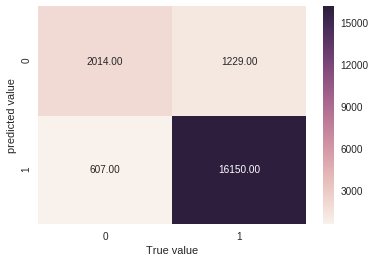

In [0]:
pred_tf=mn_r_tf.predict(test_tf)
print(metrics.classification_report(y_test,pred_tf))

print('*'*50)

cnf_mat=metrics.confusion_matrix(y_test,pred_tf)
pd.DataFrame(cnf_mat,index=[0,1],columns=[0,1])
sns.heatmap(df,annot=True,fmt='0.2f')
plt.xlabel('True value')
plt.ylabel('predicted value')
plt.show()